In [28]:
# from src.utils import * 
from src.utils import cleaning, eda, config, sktools, metrics
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, \
                                MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
import warnings 
warnings.simplefilter('ignore')
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

### Simple Data Cleaning

In [2]:
# Load the original dataset
df = cleaning.load_data(config.ORIG_DATA_PATH)
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [3]:
# Data cleaning
df = cleaning.drop_nan(df, verbose=True)

Dropped 24 rows, 0.13% of original rows


In [4]:
# Formatting index and column names
df = cleaning.format_data(df)
df.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [5]:
# Value counts file dump
cleaning.dump_value_counts(config.VALUE_COUNTS_PATH, df, verbose=True)

Value counts information has been printed to src/data/tmp/value_counts.txt


In [6]:
# Save cleaned data
df.to_csv(config.CLEANED_DATA_PATH)

### EDA

In [7]:
# Load cleaned dataset
df = cleaning.load_data(config.CLEANED_DATA_PATH, index_col=0)
eda.report(df)

,nan_count,dtype,unique
offer_accepted,0,object,2
reward,0,object,3
mailer_type,0,object,2
income_level,0,object,3
bank_accounts_open,0,int64,3
overdraft_protection,0,object,2
credit_rating,0,object,3
credit_cards_held,0,int64,4
homes_owned,0,int64,3
household_size,0,int64,8


In [8]:
# Statistics of numerical features of the dataset
df.describe()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,1.255730,1.903427,1.203549,3.499110,940.515562,910.450656,999.392190,1042.033600,810.185803
std,0.472405,0.797086,0.427446,1.114476,350.297837,620.077060,457.402268,553.452599,559.001365
min,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000,363.000000
50%,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000,703.000000
75%,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000
max,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


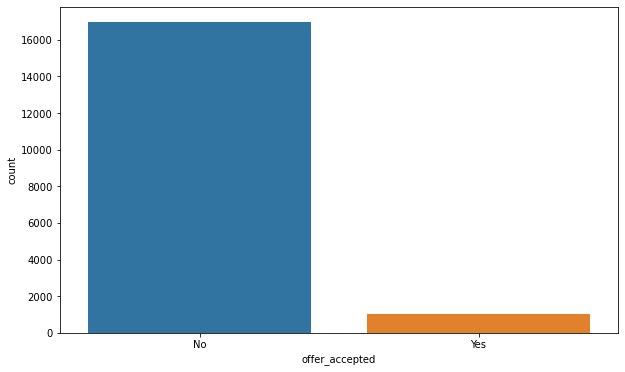

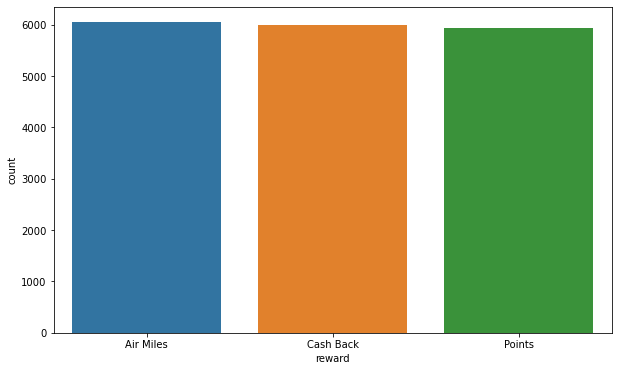

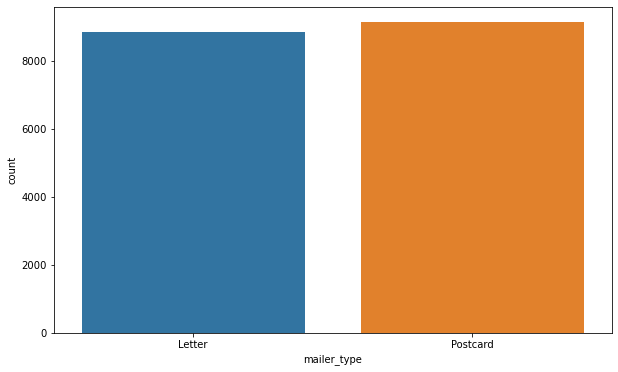

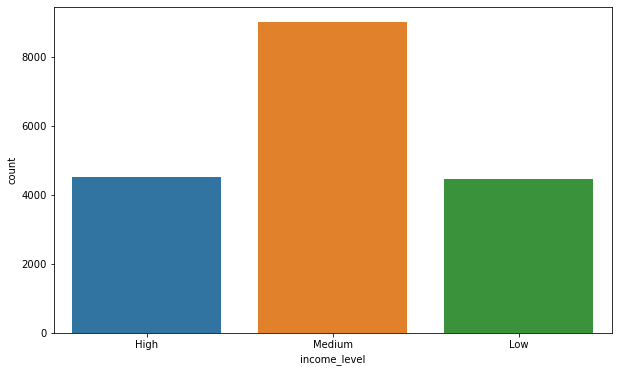

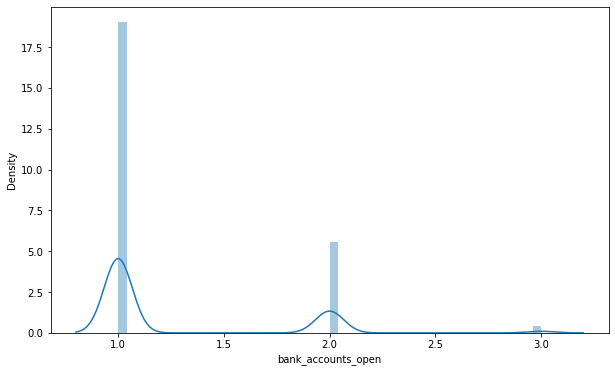

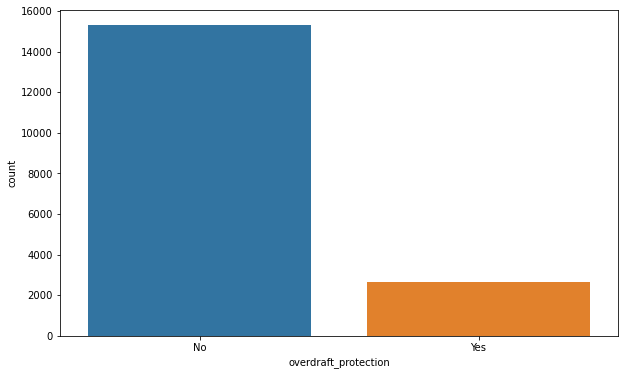

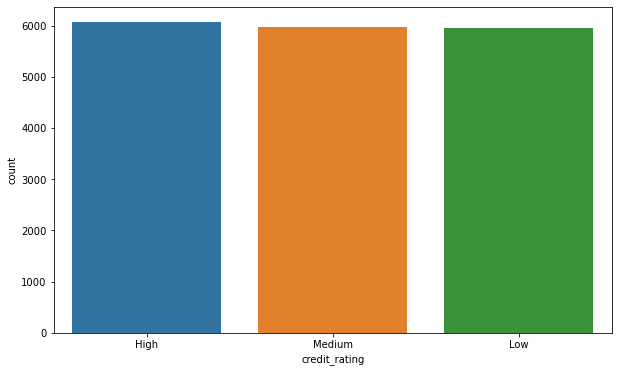

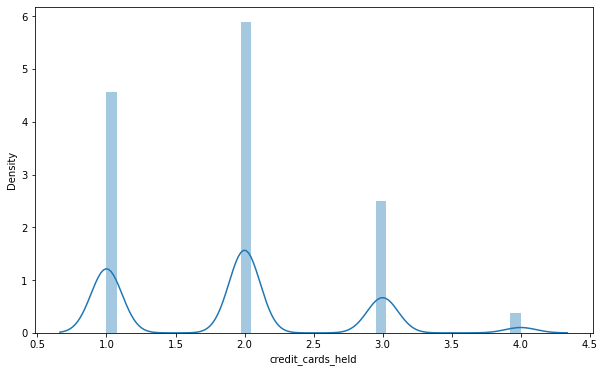

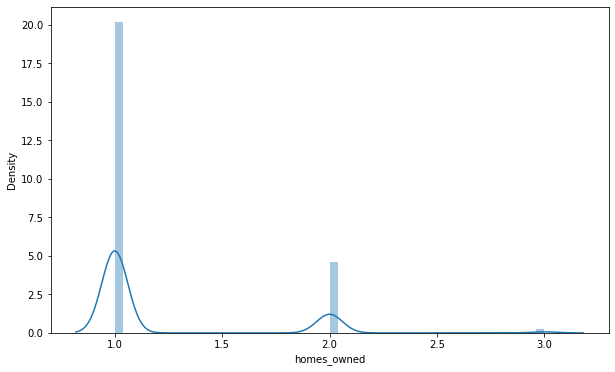

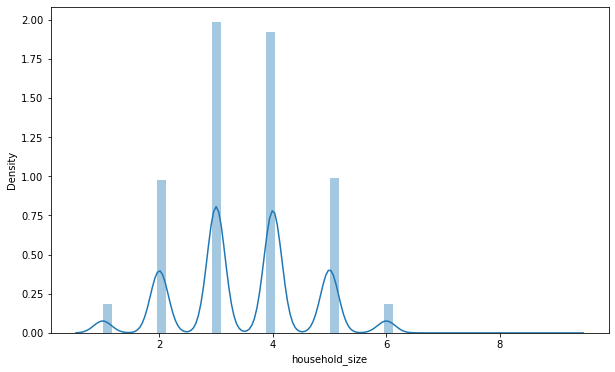

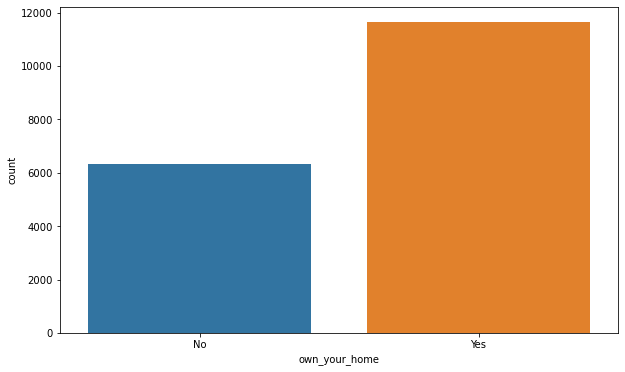

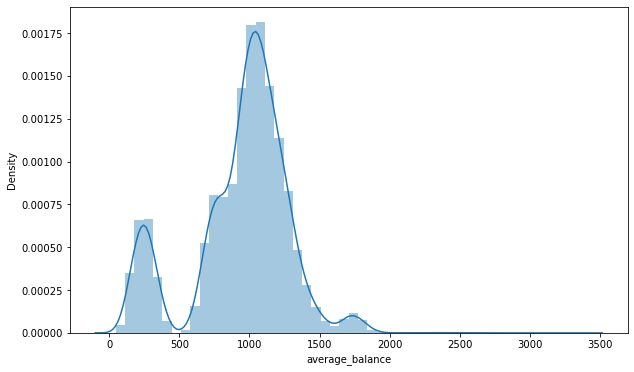

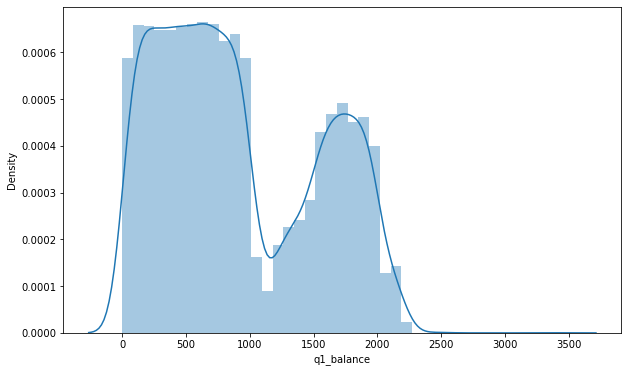

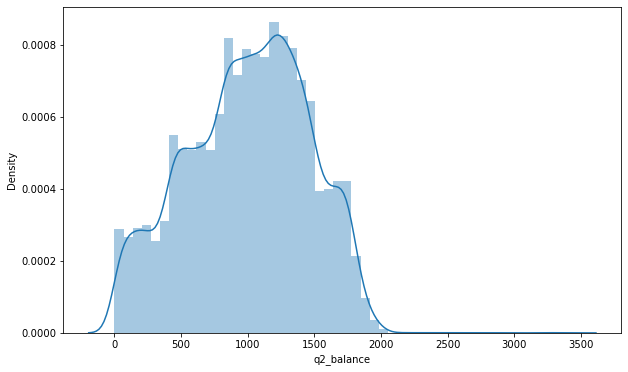

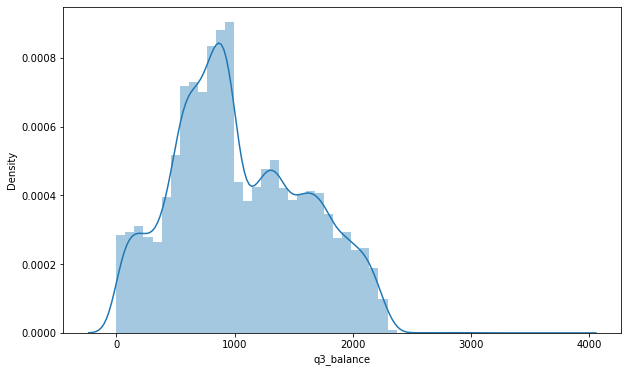

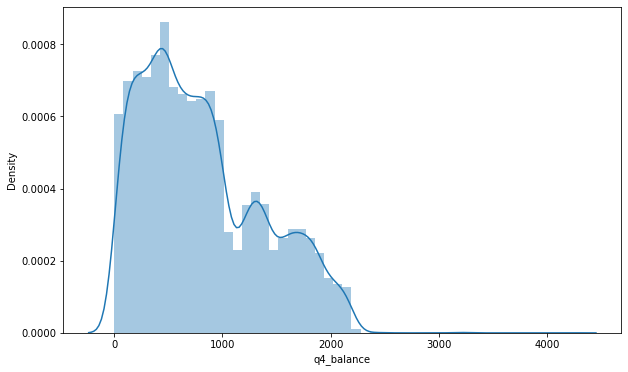

In [9]:
# Take a look at some distributions
eda.plot_distributions(df, (10, 6))

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

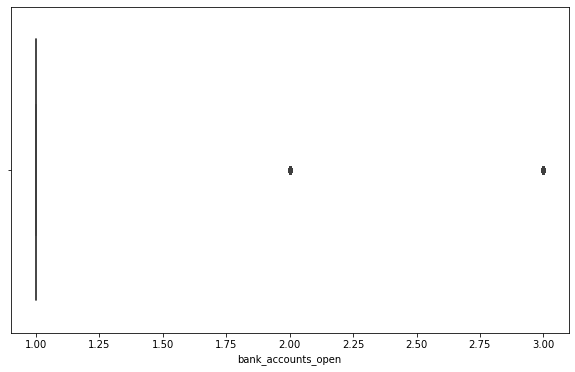

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

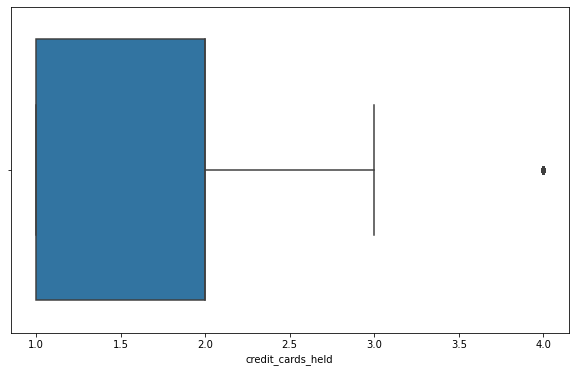

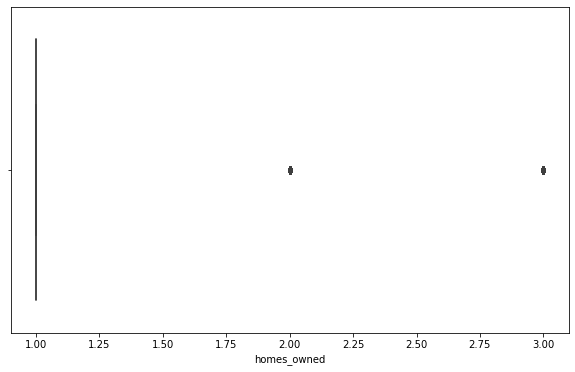

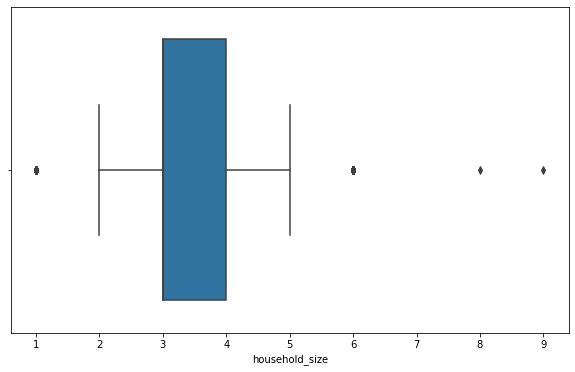

<Figure size 720x432 with 0 Axes>

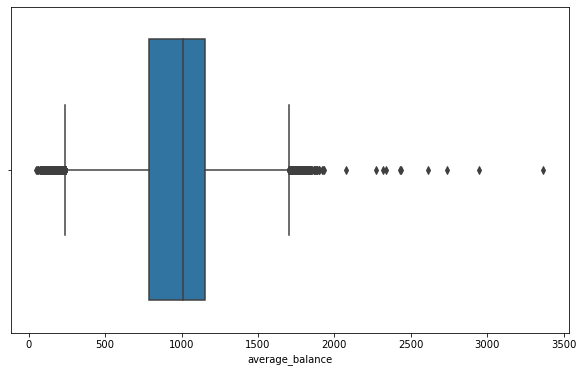

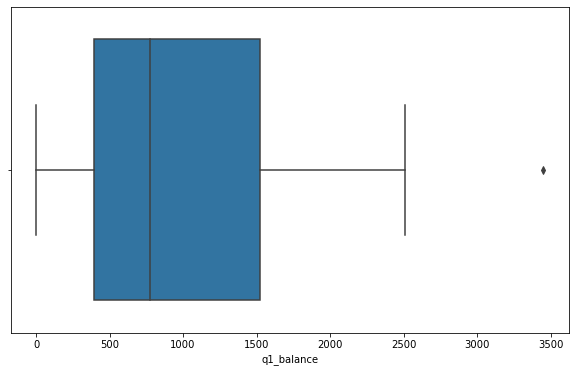

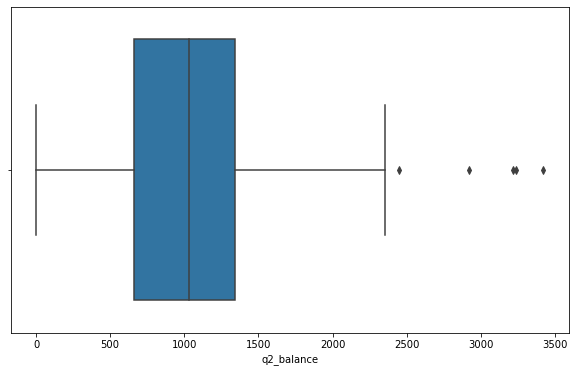

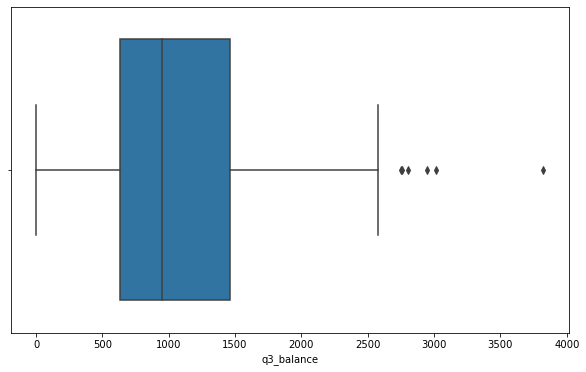

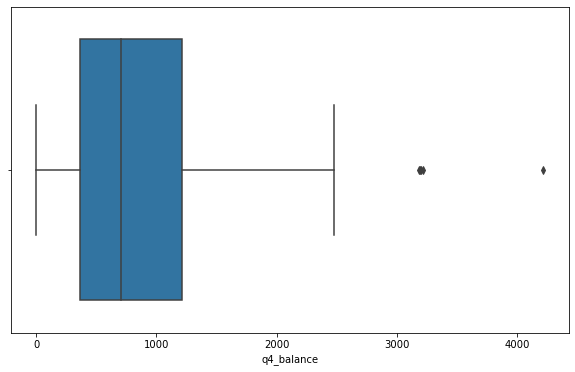

In [10]:
# Take a look to the outliers
eda.plot_outliers(df, (10, 6))

It probably will be useful to drop outliers from the balances. <br>
Final desicion will be made during model definition and tuning

In [11]:
# drop outliers from selected columns
df_wo = sktools.remove_outliers(df, skip_columns=eval(config.SKIP_DROP_OUTLIERS),
                                verbose=True, threshold=1.5)

Outliers removal has removed 1442 rows (8.02 % of initial size)


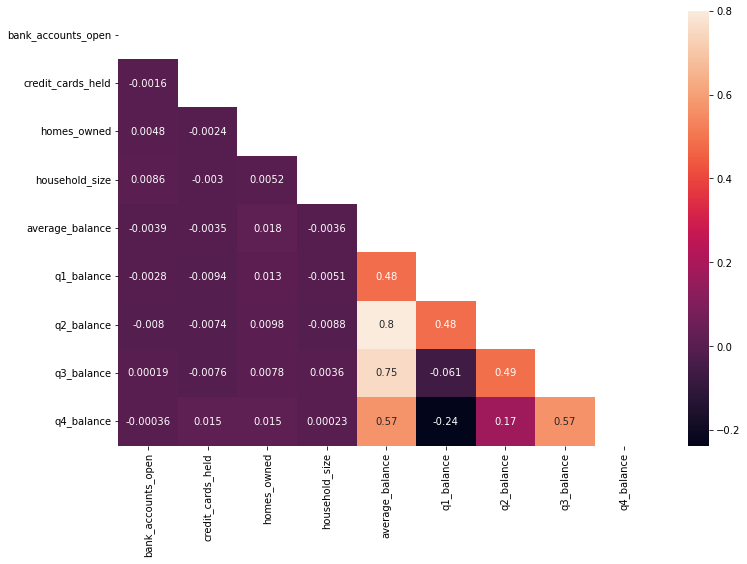

In [12]:
# Take a look to correlation heatmap
eda.show_corr_heatmap(df, figsize=(12, 8))

In [13]:
# Following couples present multicollinearity
multicoll = eda.report_multicoll(df)
multicoll

,feat1,feat2,corr
0,average_balance,q2_balance,0.800285
1,average_balance,q4_balance,0.572380
2,average_balance,q1_balance,0.481507
3,average_balance,q3_balance,0.752741
4,q1_balance,q2_balance,0.483134
5,q2_balance,q3_balance,0.487710
6,q3_balance,q4_balance,0.565298


### Benchmark Models
In following sections the Benchmark models are presented in order to get an <br>
initial idea on the different classifiers perform with a raw dataset with minimal <br>
changes. The classifier analized are:
- Logistic Regression
- Naive Bayes (Multinomial)
- Naive Bayes (Gaussian)
- K-Neares Neighbors
- Support Vector Machine (SVC)
- Decision Tree (Random Forest Classifier)

Models are implemented all with the same modifications on the dataset:
- MinMax applied to numerical data, due to costraints on Naive Bayes
- One Hot Encoder applied to categorical data
- No feature engineer/reduction
- No consideration of Multicollinearity
- Yes balancing the dataset
- No outliers dropped
- No parameters tuning on the models

In [39]:
# Benchmark config
cols_onehot_encod = eval(config.COLS_ONEHOT_ENCODE)
target = config.TARGET
models = [LogisticRegression(), MultinomialNB(), GaussianNB(), KNeighborsClassifier(), 
          SVC(), RandomForestClassifier()]
scaler = MinMaxScaler()
encoder = OneHotEncoder()

In [40]:

# Benchmark models performances
for model in models:
    print('Model: ', str(model).strip('()')) 
    predictions, report = sktools.score_classification_model(
                            df=df,
                            target=target,
                            model=model,
                            cols_to_encode=[cols_onehot_encod],
                            scaler=scaler,
                            encoders=[encoder],
                            balance_dataset=True,
                            balancer=SMOTE()
    )
    print(report, end='\n\n')

Model:  LogisticRegression
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.12      0.72      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.70      0.50      4494
weighted avg       0.93      0.67      0.76      4494


Model:  MultinomialNB
              precision    recall  f1-score   support

          No       0.98      0.67      0.79      4241
         Yes       0.12      0.74      0.20       253

    accuracy                           0.67      4494
   macro avg       0.55      0.70      0.50      4494
weighted avg       0.93      0.67      0.76      4494


Model:  GaussianNB
              precision    recall  f1-score   support

          No       0.97      0.71      0.82      4241
         Yes       0.12      0.64      0.20       253

    accuracy                           0.70      4494
   macro avg       0.54      0.68      0.51      4494
weig

### Models optimization
1. Scaling methods
2. Encoding methods
3. Outliers handling
4. Multicollinearity 
5. Balancing methods
6. ML model tuning

Logistic Regression and Naive Bayes (Multinomial) models seem to have the best <br> 
performance on the classificaion. <br>
#### Why???
Logistic Regression and Naive Bayes (multinomial) will now be optimized and lastly <br>
a Grid Optimization will be tried on the SVC (and maybe Random forests) to see if a <br> 
computationally more expensive algorithm can outperform these two simple models.


#### 1. Scaling Methods

#### 2. Encoding Methods

#### 3. Outliers (threshold optimization)

#### 4. Multicollinearity

With multicollinearity accounted, I see strong relation with avg_balance and <br> all the q-balances. As a first measure I drop avg_balance and I keep only <br> q1 and q3 balances due to their low correlation factors (more distance <br> in time). Model increase precision from 0.20 to 0.25.

#### 5. Balancing Methods (Can SMOTE() be tuned? and Tomek Links?)

#### 6. SVC optimization

### Metrics of our model

              precision    recall  f1-score   support

          No       0.98      0.67      0.79      5079
         Yes       0.12      0.76      0.21       314

    accuracy                           0.67      5393
   macro avg       0.55      0.71      0.50      5393
weighted avg       0.93      0.67      0.76      5393



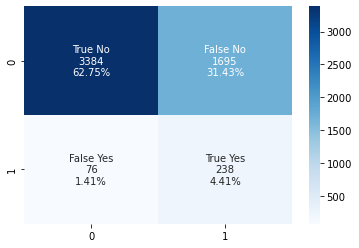

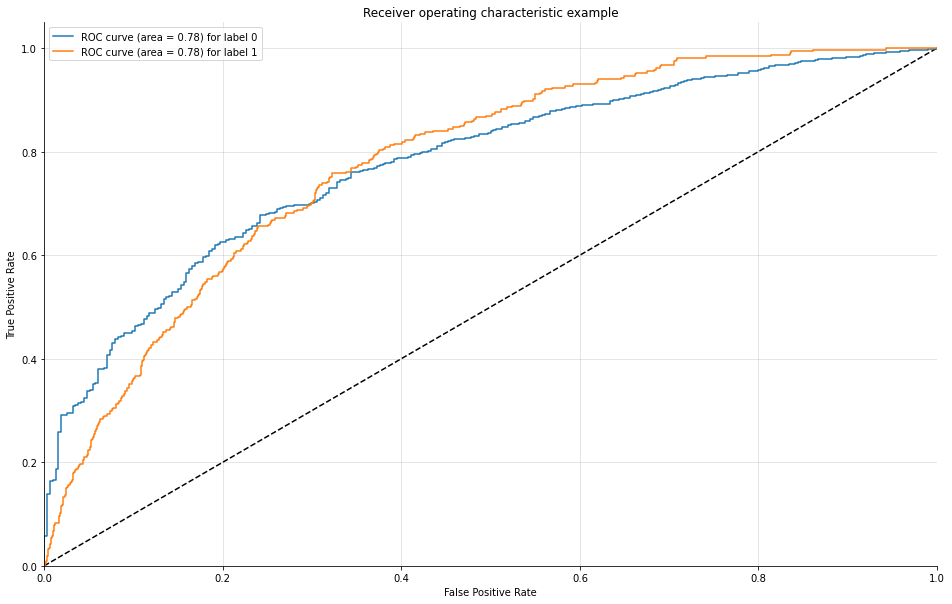

In [35]:
# test metrics funcs

df = cleaning.load_data(config.CLEANED_DATA_PATH)
cols_onehot_encod = ['reward', 'mailer_type', 'overdraft_protection', 
                'own_your_home', 'income_level', 'credit_rating']
X_train, X_test, y_train, y_test = sktools.split_data(df,
                                                    target = config.TARGET,
                                                    test_size=0.3,
                                                    random_state=42)
sktools.scale_data(X_train, X_test, scaler_class=MinMaxScaler())
X_train, X_test = sktools.encode_data(X_train, X_test, encoders=[OneHotEncoder()],
                                        cols_to_encode=[cols_onehot_encod])
balancer = SMOTE()
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_pred = sktools.apply_model(X_train, X_test, y_train, model=MultinomialNB(),
                                return_formula=False, k=None)
print(classification_report(y_test, y_pred))
metrics.plot_confusion_matrix(y_test, y_pred)
metrics.plot_multiclass_roc(MultinomialNB().fit(X_train, y_train),
                                X_test, y_test, n_classes=2,
                                figsize = (16, 10))

### Conclusions

It seems we have found our model for our business problem. With the multinomial <br>
Naive Bayes algorithm we reach a recall (sensitivity) up to 75%. In these business <br>
problems recall is the most important parameter beacuse is more useful to try to <br>
find (predict) all the 'Yes' for the card-offer acceptance. Accuracy is low (0.11-0.12) <br>
and that implies that we are going to predict a lot of 'Yes' that are actually 'No' <br>
but if the company is not limited on the searching process, an high sensitivity <br>
allows us to be sure at 75% that the found 'Yes' is actually a 'Yes'. <br>
